In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mkdir datafold

In [ ]:
!unzip /content/drive/"My Drive"/"UCSD 200"/Birds525.zip -d /content/datafold

Streaming output truncated to the last 5000 lines.
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/164.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/165.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/166.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/167.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/168.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/169.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/170.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/171.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/172.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/173.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/174.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/175.jpg  
  inflating: /content/datafold/Birds525/train/WILLOW PTARMIGAN/176.jpg  


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [ ]:
# Path to your dataset
train_data_path = '/content/datafold/Birds525/train'
validation_data_path = '/content/datafold/Birds525/valid'

In [ ]:
# Define inputs for anchor, positive, and negative images
anchor_input = Input(shape=(224, 224, 3), name='anchor_input')
positive_input = Input(shape=(224, 224, 3), name='positive_input')
negative_input = Input(shape=(224, 224, 3), name='negative_input')

# Define the triplet loss function
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]

    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)

    return K.mean(loss)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create the metric learning model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation=None),  # Embedding layer
    Lambda(lambda x: K.l2_normalize(x, axis=1))  # L2 normalization
])



In [ ]:
# Generate embeddings for anchor, positive, and negative images
anchor_embedding = model(anchor_input)
positive_embedding= model(positive_input)
negative_embedding = model(negative_input)

# Concatenate embeddings to feed into the custom loss function
merged_output = tf.concat([anchor_embedding, positive_embedding, negative_embedding], axis=1)

# Define the full model
full_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
# Create a triplet generator
def triplet_generator(data_path, batch_size=32):
    class_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    while True:
        anchors = []
        positives = []
        negatives = []

        for _ in range(batch_size):
            # Randomly select two different classes
            pos_class, neg_class = np.random.choice(class_dirs, 2, replace=False)

            # Get all images in the positive class
            pos_images = os.listdir(os.path.join(data_path, pos_class))

            # Select anchor and positive
            anchor_img, positive_img = np.random.choice(pos_images, 2, replace=False)

            # Select a negative image
            neg_images = os.listdir(os.path.join(data_path, neg_class))
            negative_img = np.random.choice(neg_images)

            # Load and preprocess images
            anchor = preprocess_image(os.path.join(data_path, pos_class, anchor_img))
            positive = preprocess_image(os.path.join(data_path, pos_class, positive_img))
            negative = preprocess_image(os.path.join(data_path, neg_class, negative_img))

            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)

        # Stack the images to create batch tensors
        anchors = np.stack(anchors)
        positives = np.stack(positives)
        negatives = np.stack(negatives)

        # Create dummy labels
        dummy_y = np.zeros((batch_size,))

        yield [anchors, positives, negatives], dummy_y


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array[0]

In [ ]:
# Set up the data generators
train_gen = triplet_generator(train_data_path)
val_gen = triplet_generator(validation_data_path)

In [ ]:

full_model.compile(optimizer=Adam(learning_rate=0.0001), loss=triplet_loss)

history = full_model.fit(
    train_gen,
    steps_per_epoch=100,  # Adjust based on your dataset size
    epochs=20,
    validation_data=val_gen,
    validation_steps=50  # Adjust based on your validation dataset size
)


Epoch 1/20
100/100 [==============================] - 244s 2s/step - loss: 0.0428 - val_loss: 0.0253
Epoch 2/20
100/100 [==============================] - 246s 2s/step - loss: 0.0332 - val_loss: 0.0175
Epoch 3/20
100/100 [==============================] - 244s 2s/step - loss: 0.0340 - val_loss: 0.0196
Epoch 4/20
100/100 [==============================] - 243s 2s/step - loss: 0.0291 - val_loss: 0.0153
Epoch 5/20
100/100 [==============================] - 244s 2s/step - loss: 0.0246 - val_loss: 0.0143
Epoch 6/20
100/100 [==============================] - 243s 2s/step - loss: 0.0250 - val_loss: 0.0151
Epoch 7/20
100/100 [==============================] - 243s 2s/step - loss: 0.0240 - val_loss: 0.0127
Epoch 8/20
100/100 [==============================] - 243s 2s/step - loss: 0.0242 - val_loss: 0.0123
Epoch 9/20
100/100 [==============================] - 249s 2s/step - loss: 0.0198 - val_loss: 0.0144
Epoch 10/20
100/100 [==============================] - 249s 2s/step - loss: 0.0239 - val_lo

In [ ]:
#Prepare test data

test_data_path = '/content/datafold/Birds525/test'

test_gen = triplet_generator(test_data_path)


In [ ]:
# Evaluate the model on the test data
test_loss = full_model.evaluate(test_gen, steps=50)  # Adjust steps based on your test dataset size

print(f'Test Loss: {test_loss}')

50/50 [==============================] - 80s 2s/step - loss: 0.0097
Test Loss: 0.009686336852610111


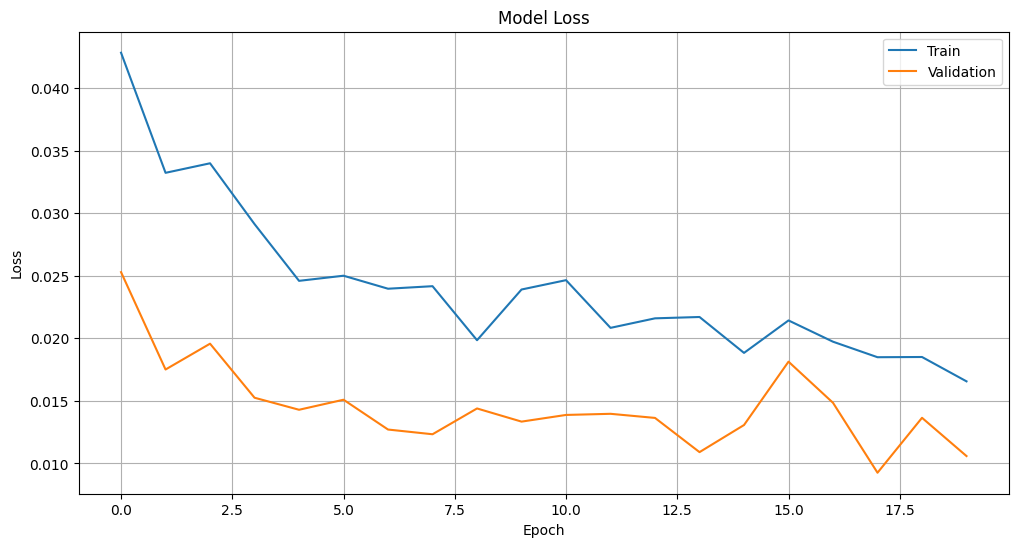

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

In [ ]:
# Save the entire model to a file
model_save_path = '/content/Metric_Learning_model.h5'
full_model.save(model_save_path)
